In [1]:
# ASEN6008 HW8

## Imports

In [2]:
import numpy as np
from propagators import ode_solve, halomaker, yzero, yzero2
import matplotlib.pyplot as plt
from astro_constants import EARTH_MOON_CENTER

# Givens

In [3]:
mu = EARTH_MOON_CENTER
L = 384747.962856037
r0 = np.vstack([1.14,0,-.16])
v0 = np.vstack([0,-0.223,0])
phi = np.eye(2*len(v0))
phi = np.reshape(phi,newshape=(36,1))
inits = np.vstack([r0,v0,phi])
tol = 1e-12
corrections = [1e3,1e3]

## Corrections

42
42
42
42
42
[[ 1.14      ]
 [ 0.        ]
 [-0.16337975]
 [ 0.        ]
 [-0.22343156]
 [ 0.        ]]


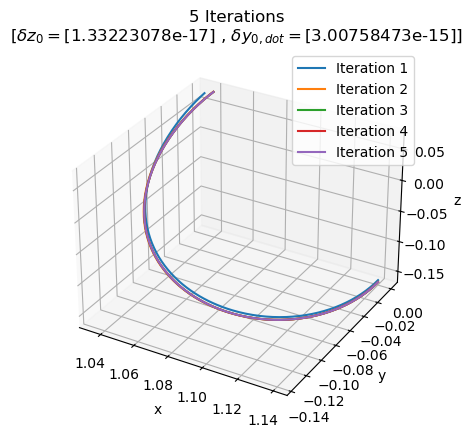

In [4]:
#plot
plt.figure(1)
ax = plt.axes(projection='3d', adjustable='box')
count = 0
tspan = np.linspace(0, 2*np.pi, 1000)
yzero.terminal=True
yzero.direction=1
while abs(corrections[0])>tol or abs(corrections[1])>tol:
    count = count+1
    #ODE
    orb_struct = ode_solve(fun=halomaker,tspan=tspan, init_state = inits, events=yzero)
    orb_coord = orb_struct.y
    orb_stop_dum = orb_struct.y_events[0]
    print(orb_stop_dum.size)
    if orb_stop_dum.size!=0:
        orb_stop = orb_struct.y_events[0][0]
            #define R1 and R2
        x = orb_stop[0]
        y = orb_stop[1]
        z = orb_stop[2]
        ydot= orb_stop[4]
        R1 = np.linalg.norm([x+mu,y,z])
        R2 = np.linalg.norm([x-1+mu,y,z])
        
        #velocity change
        xddot = 2*ydot + x - (1-mu)*(x+mu)/R1**3 - mu*(x-1+mu)/R2**3
        zddot = -(1-mu)*z/R1**3 - mu*z/R2**3

        #make the correction
        phi_vec = orb_stop[6:]
        phi_mat = np.reshape(phi_vec,newshape=(6,6))
        r_vec = orb_stop[:3]
        dxdot = orb_stop[3]
        dzdot = orb_stop[5]
        correction_mat = np.array([[phi_mat[3,2],phi_mat[3,4]],
                        [phi_mat[5,2], phi_mat[5,4]]])
        extra_bit = 1/ydot*np.outer(np.vstack([xddot,zddot]),np.hstack([phi_mat[1,2],phi_mat[1,4]]))
        correction_mat -= extra_bit
        corrections = np.linalg.inv(correction_mat) @ np.vstack([-dxdot,-dzdot])
        r0[2] = r0[2] + corrections[0]
        v0[1] = v0[1] + corrections[1]
        inits = np.vstack([r0,v0,phi])
        plt.plot(orb_coord[0,:],orb_coord[1,:],orb_coord[2,:], label=f'Iteration {count}')
    else:
        break


#plotting
plt.grid
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
#ax.set_box_aspect((np.ptp(orb_coord[0,:]), np.ptp(orb_coord[1,:]), np.ptp(orb_coord[2,:])))
plt.title(f'{count} Iterations\n['+r'$\delta z_0=$'+f'{corrections[0]}'+' , '+r'$\delta y_{0,dot}=$'+f'{corrections[1]}]')
plt.legend()
#inits(1:6)
print(inits[:6])
plt.show()

## Final Output

Period:	13.516


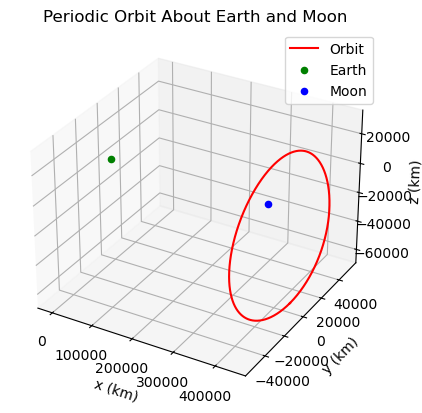

In [5]:
plt.figure(2)
yzero.direction=-1
yzero.terminal=0
sol = ode_solve(fun=halomaker,tspan=np.linspace(0,2*np.pi, 2000),init_state=inits, events=yzero)
one_orbit = sol.t_events[0][1]
sol = ode_solve(fun=halomaker,tspan=np.linspace(0, one_orbit, 2000),init_state=inits)
orb_coords = sol.y

#plotting
ax = plt.axes(projection='3d')#, adjustable='box')
ax.plot(L*orb_coords[0,:],L*orb_coords[1,:],L*orb_coords[2,:], color='r', label='Orbit')
ax.scatter(L*(-mu),0,0, color='g', marker='o', label='Earth')
ax.scatter(L*(1-mu),0,0, color='b', marker='o', label='Moon')
#set(gca,'color','k')
plt.grid
#set(gca,'gridcolor',[1,1,1])
#set(gca,'textcolor',[1,1,1])
plt.xlabel('x (km)')
plt.ylabel('y (km)')
ax.set_zlabel('z (km)')
all_positions = np.concatenate([orb_coords[:3,:], np.vstack([L*(-mu),0,0]), np.vstack([L*(1-mu),0,0])], axis=1)
xlims = np.ptp(all_positions[0,:])
#ax.set_box_aspect((xlims, np.ptp(all_positions[1,:]), np.ptp(all_positions[2,:])))
plt.title('Periodic Orbit About Earth and Moon')
plt.legend()


non_t = one_orbit
GM_em = 4.035032351966808e14*1e-9
P = 2*np.pi*np.sqrt(L**3/GM_em)
n = 2*np.pi/P
Period = non_t/n/86400
print(f'Period:\t{Period:.3f}')
plt.show()